### Imports

In [1]:
import sys
sys.path.append('../popalign/')
import popalign as PA
import importlib

In [2]:
PA.__file__

'../popalign/popalign.py'

### Load data
Run the first cell if samples are stored individually  
Run the second cell if samples are stored in the same matrix (requires meta data file)

In [ ]:
# Load samples from distinct matrix files
mysamples = {
    'CTRL' : '../data/samples/PBMC.mtx',
    'GMCSF_1ng/ml' : '../data/samples/GMCSF.mtx',
    'IFNG_1ng/ml' : '../data/samples/IFNG.mtx',
    'IL2_10ng/ml' : '../data/samples/IL2.mtx',
    'CD40L_20ng/ml' : '../data/samples/CD40L.mtx',
}
mygenes = '../data/samples/genes.tsv'

pop = PA.load_samples(samples=mysamples, 
                      genes=mygenes,
                      outputfolder='output_samples')

In [3]:
# Load samples from one matrix file with metadata
# (must include cell_barcode, sample_id columns)
mymatrix = '../data/screen/PBMC-MULT-4/pbmcmult4cd3minus.mtx'
mybarcodes = '../data/screen/PBMC-MULT-4/barcodes.tsv'
mygenes = '../data/screen/PBMC-MULT-4/features.tsv'
mymetadata = '../data/screen/PBMC-MULT-4/meta.csv'

pop = PA.load_multiplexed(matrix=mymatrix, 
                     barcodes=mybarcodes, 
                     metafile=mymetadata, 
                     genes=mygenes,
                     outputfolder='output_multiplexed_test',
                     only=[], # list of sample names to only load the specified samples
                     col=None, # either None or a column name from the meta data
                     value=None) # if col != None, specify value in column to filter samples

### Normalize and gene filter

In [4]:
# Perform column normalization
# Find best normalization factor
PA.normalize(pop, scaling_factor=None, ncells=None)

Performing column normalization
Finding best scaling factor


1506 genes selected


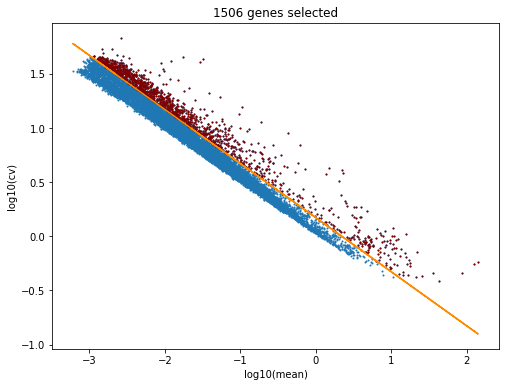

In [6]:
# Plot genes (log cv ~ log cv) and filtering line --use multiple times to find best offset (usually between .7 and 1.5)
PA.plot_gene_filter(pop, offset=1.22)

In [7]:
# Gene filter the data with the last offset value used in the previous step
PA.filter(pop, remove_ribsomal=True)

Removing ribosomal genes
Filtering genes ang logging data


In [ ]:
# Remove red blood cells from the data
PA.removeRBC(pop, species='human')

### Dimensionality reduction

In [8]:
# Generate multiple feature spaces and pick the best one based on reconstruction error
# Run GSEA on each feature
# Generate QC plots
PA.onmf(pop, ncells=5000, nfeats=[5,7], nreps=3, niter=500)

Computing W matrices
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #0
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #100
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #200
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #300
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #400
......... Iteration #499
Orthogonal NMF performed with 500 iterations

......... Iteration #499
......... Iteration #499
Orthogonal NMF performed with 500 iterations

Orthogonal NMF performed with 500 iterations

......... Iteration #499
Ort

### Build probabilistic models

In [9]:
# Build a Gaussian Mixture model for each sample
# Type the models subpopulations
PA.build_gmms(pop, 
              ks=(4,7), 
              niters=1, 
              training=.8, 
              nreplicates=0,
              reg_covar=True, 
              rendering='grouped', 
              types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
              figsizegrouped=(20,20),
              figsizesingle=(6,5))

Building model for Meprednisone (1 of 41)
Building model for Dexrazoxane HCl (ICRF-187, ADR-529) (2 of 41)
Building model for Etodolac (3 of 41)
Building model for Phenylbutazone (4 of 41)
Building model for Pomalidomide (5 of 41)
Building model for Budesonide (6 of 41)
Building model for Loteprednol etabonate (7 of 41)
Building model for CTRL (8 of 41)
Building model for Betamethasone Valerate (9 of 41)
Building model for Febuxostat (10 of 41)
Building model for Sulfasalazine (11 of 41)
Building model for Flurbiprofen (12 of 41)
Building model for Mianserin HCl (13 of 41)
Building model for Naproxen Sodium (14 of 41)
Building model for Triamcinolone Acetonide (15 of 41)
Building model for Acetylcysteine (16 of 41)
Building model for Everolimus (RAD001) (17 of 41)
Building model for Isotretinoin (18 of 41)
Building model for Ibuprofen (19 of 41)
Building model for Doramapimod (BIRB 796) (20 of 41)
Building model for Allopurinol Sodium (21 of 41)
Building model for Tranilast (22 of 41)


In [ ]:
# If the renderings do not have the right figure size, regenerate the renderings with:
#PA.render_models(pop, figsizegrouped=(20,20), figsizesingle=(6,5), mode='grouped')

### Align subpopulations

In [10]:
# Align subpopulations of each sample against a reference model's subpopulations
PA.align(pop, ref='CTRL', method='conservative', figsizedeltas=(10,10), figsizeentropy=(10,10))

In [12]:
# Get list of differentially expressed genes between a reference subpopulation
# and a sample's subpopulation that aligned to it
refcomp = 0
sample = 'Budesonide'
importlib.reload(PA)

genelist = PA.diffexp(pop,
                      refcomp=refcomp,
                      sample=sample,
                      nbins=20, 
                      nleft=15,
                      nright=15,
                      renderhists=True,
                      usefiltered=True)

In [ ]:
importlib.reload(PA)
PA.plot_heatmap(pop,
                refcomp=refcomp,
                genelist=genelist,
                cluster=True, 
                savename='%d_%s' % (refcomp,sample) ,# either None or a string
                figsize=(20,20),
                cmap='Purples',
                samplelimits=False,
                scalegenes=True,
                only=None)

### Visualize genes in subpopulations

In [16]:
importlib.reload(PA)
PA.plot_genes_gmm_cells(pop,
               sample='unique',
               genelist=genelist,
               savename='',
               metric='correlation',
               method='single',
               clustergenes=False,
               clustercells=False,
               cmap='magma',
               figsize=(15,15)
)

### Rank samples

In [20]:
# Rank each sample against a reference sample's model
importlib.reload(PA)
PA.rank(pop,
        ref='CTRL', # label of the reference sample
        k=100, # number of cells to randomly sample from sample
        niter=200, # number of iterations
        method='LLR', # LLR for log-likelihood ratio or LL for log-likelihood
        mincells=50, # sample's minimum number of cells to be ranked
        figsize=(10,5)) # plot figure size

### Build unique GMM for all samples

In [11]:
# Build a unique GMM for the samples concatenated together
importlib.reload(PA)
PA.build_unique_gmm(pop, 
                    ks=(5,20), 
                    niters=3, 
                    training=0.2, 
                    reg_covar=True, 
                    types='defaultpbmc', # either None, 'defaultpbmc' or a dictionary
                    figsize=(6,5))

In [ ]:
# Generate a query plot
PA.plot_query(pop,  pcells=.2, nreps=10, figsize=(5,20), sharey=True)

### 3D visualization

In [ ]:
# Interactive 3D visualization of the data in feature space
importlib.reload(PA)
import plotly
plotly.offline.init_notebook_mode()
PA.plotfeatures(pop)

### Work in progress

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#-------------- WORK IN PROGRESS BELOW ----------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [ ]:
M = PA.cat_data(pop,'M') # get the full (genes,cells) matrix
gene = 'CD3D' # gene name
igene = np.where(pop['genes']==gene)[0][0] # index of gene
sub = M[igene,:] # get gene row in the matrix
print(sub.mean()) # mean of gene across all cells
print(sub.data.mean()) # mean of gene across cells with non-zero expression for that gene

In [ ]:
LIST = ['CD3D','CD226']
for gene in LIST:
    igene = np.where(pop['genes']==gene)[0][0] # index of gene
    sub = M[igene,:] # get gene row in the matrix
    print(gene)
    print('Num of cells expressing: %d' % len(sub.data))
    print('Mean across all cells:',sub.mean()) # mean of gene across all cells
    print('Mean across expressing cells:',sub.data.mean(),'\n') # mean of gene across cells with non-zero expression for that gene

In [ ]:
X = pop['samples']['CTRL']['C']

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
X = PA.cat_data(pop, 'C')

In [ ]:
pop['umap'] =  umap.UMAP().fit_transform(X)

In [ ]:
X = pop['umap']

In [ ]:
X = test

In [ ]:
c = [pop['samples'][x]['C'].shape[0] for x in pop['order']]
c = np.concatenate([[i]*x for i,x in enumerate(c)])

In [ ]:

plt.scatter(X[:,0], X[:,1], s=1, c=c, cmap='tab20')

In [ ]:
c

In [ ]:
import numpy as np

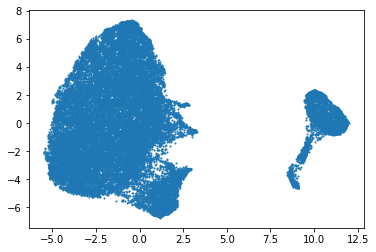

In [18]:
importlib.reload(PA)
PA.scatter(pop, method='umap')